Reproducing the results of "The Three Types Of Adam Sandler Movies" on FiveThirtyEight: http://fivethirtyeight.com/datalab/the-three-types-of-adam-sandler-movies/

## Versions

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=4, micro=3, releaselevel='final', serial=0)

In [2]:
import requests
requests.__version__

'2.6.2'

In [3]:
import bs4
from bs4 import BeautifulSoup
bs4.__version__

'4.3.2'

In [4]:
import numpy as np
np.__version__

'1.9.2'

In [5]:
import pandas as pd
pd.__version__

'0.16.0'

In [6]:
from sklearn.cluster import KMeans

import sklearn
sklearn.__version__

'0.16.1'


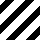
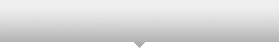
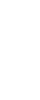
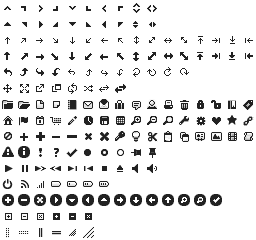
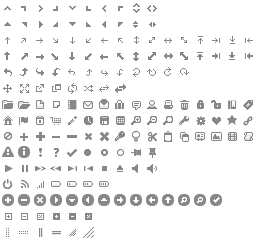
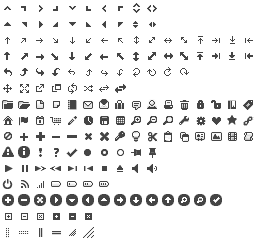
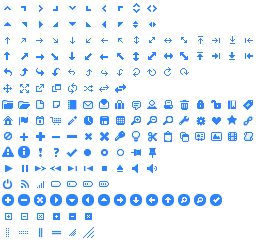
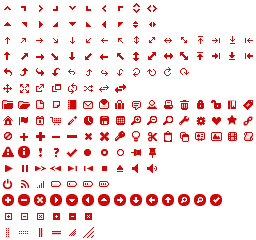
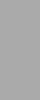
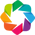
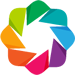
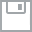
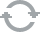
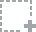
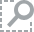
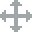
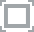
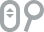

'0.8.2'

In [7]:
import bokeh.plotting as plt
from bokeh.models import HoverTool
plt.output_notebook()

import bokeh
bokeh.__version__

## Getting Data

Original article is based on [Rotten Tomatoes](http://www.rottentomatoes.com/celebrity/adam_sandler/) for ratings and [Opus Data](http://www.opusdata.com) for the Box Office Gross. The second one is behind a paywall so it was replaced it with the same the Box Office data on Rotten Tomatoes.

We get the html from rottern tomatoes and pass it to beautiful soup so we can extract the content we want.
Then we used [selector gadget](http://selectorgadget.com/) to get the CSS selector of the table that we can pass to pandas and they will return a nice DataFrame.

In [8]:
def get_soup(url):
    r = requests.get(url)
    return BeautifulSoup(r.text, 'html5lib')

In [9]:
rotten_sandler_url = 'http://www.rottentomatoes.com/celebrity/adam_sandler/'

In [10]:
soup = get_soup(rotten_sandler_url)

In [11]:
films_table = str(soup.select('#filmography_box table:first-child')[0])

In [12]:
rotten = pd.read_html(films_table)[0]

In [13]:
rotten.head()

RATING                   TITLE                             CREDIT  \
0    NaN             Hello Ghost                     Actor Producer   
1     9%             The Cobbler                         Max Simkin   
2    NaN                  Pixels  Producer Screenwriter Sam Brenner   
3    NaN              Candy Land                              Actor   
4     6%  Paul Blart: Mall Cop 2                           Producer   

  BOX OFFICE  YEAR  
0         --  2015  
1         --  2015  
2         --  2015  
3         --  2015  
4     $43.2M  2015

We convert the "Rating" and "Box Office" columns to numeric values with some simple transformations removing some text characters and also replacing empty values with `numpy.nan`.

In [14]:
rotten.RATING = rotten.RATING.str.replace('%', '').astype(float)

In [15]:
rotten['BOX OFFICE'] = rotten['BOX OFFICE'].str.replace('$', '').str.replace('M', '').str.replace('-', '0')
rotten['BOX OFFICE'] = rotten['BOX OFFICE'].astype(float)

In [16]:
rotten.loc[rotten['BOX OFFICE'] == 0, ['BOX OFFICE']] = np.nan

In [17]:
rotten.head()

RATING                   TITLE                             CREDIT  \
0     NaN             Hello Ghost                     Actor Producer   
1       9             The Cobbler                         Max Simkin   
2     NaN                  Pixels  Producer Screenwriter Sam Brenner   
3     NaN              Candy Land                              Actor   
4       6  Paul Blart: Mall Cop 2                           Producer   

   BOX OFFICE  YEAR  
0         NaN  2015  
1         NaN  2015  
2         NaN  2015  
3         NaN  2015  
4        43.2  2015

In [18]:
rotten = rotten.set_index('TITLE')

We finaly save the dataset.

In [19]:
rotten.to_csv('rotten.csv')

## Chart

This is the original chart for comparison

In [20]:
from IPython.display import Image

In [21]:
Image(url='https://espnfivethirtyeight.files.wordpress.com/2015/04/hickey-datalab-sandler.png?w=610&h=634')

We load the saved data into a DataFrame and we just plot using bokeh that gives some nice interactive features that the original chart do not have, this makes it easier to explore the different movies.

In [22]:
rotten = pd.read_csv('rotten.csv', index_col=0)

In [23]:
rotten = rotten.dropna()

In [24]:
len(rotten)

37

In [25]:
rotten.index

Index(['Paul Blart: Mall Cop 2', 'Blended', 'Top Five', 'Grown Ups 2', 'That's My Boy', 'Hotel Transylvania', 'Here Comes the Boom', 'Jack and Jill', 'Zookeeper', 'Just Go with It', 'Bucky Larson: Born to Be a Star', 'Grown Ups', 'Funny People', 'Paul Blart: Mall Cop', 'You Don't Mess With the Zohan', 'The House Bunny', 'Bedtime Stories', 'Strange Wilderness', 'I Now Pronounce You Chuck & Larry', 'Reign Over Me', 'Grandma's Boy', 'Click', 'The Benchwarmers', 'Deuce Bigalow: European Gigolo', 'The Longest Yard', 'Spanglish', '50 First Dates', 'Dickie Roberts: Former Child Star', 'Anger Management', 'The Hot Chick', 'Mr. Deeds', 'Adam Sandler's Eight Crazy Nights', 'The Master of Disguise', 'Punch-Drunk Love', 'Joe Dirt', 'The Animal', 'Little Nicky'], dtype='object')

In [26]:
source = plt.ColumnDataSource(
    data=dict(
        rating=rotten.RATING,
        gross=rotten['BOX OFFICE'],
        movie=rotten.index,
    )
)

p = plt.figure(tools='reset,save,hover', x_range=[0, 100], title='',
               x_axis_label="Rotten Tomatoes rating", y_axis_label="Box Office Gross")
p.scatter(rotten.RATING, rotten['BOX OFFICE'], size=10, source=source)

hover = p.select(dict(type=HoverTool))

hover.tooltips = [
    ("Movie", "@movie"),
    ("Rating", "@rating"),
    ("Box Office Gross", "@gross"),
]

plt.show(p)

## Clusters

The articles also mentioned some simple clustering on the dataset. We can reproduce that with scikit-learn.

In [27]:
X = rotten[['RATING', 'BOX OFFICE']].values

In [28]:
clf = KMeans(n_clusters=3)

In [29]:
clf.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [30]:
clusters = clf.predict(X)
clusters

array([0, 0, 2, 1, 0, 1, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0,
       0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0], dtype=int32)

In [31]:
colors = clusters.astype(str)
colors[clusters == 0] = 'green'
colors[clusters == 1] = 'red'
colors[clusters == 2] = 'gold'

In [32]:
source = plt.ColumnDataSource(
    data=dict(
        rating=rotten.RATING,
        gross=rotten['BOX OFFICE'],
        movie=rotten.index,
    )
)

p = plt.figure(tools='reset,save,hover', x_range=[0, 100], title='',
               x_axis_label="Rotten Tomatoes rating", y_axis_label="Box Office Gross")
p.scatter(rotten.RATING, rotten['BOX OFFICE'], size=10, source=source, color=colors)

hover = p.select(dict(type=HoverTool))

hover.tooltips = [
    ("Movie", "@movie"),
    ("Rating", "@rating"),
    ("Box Office Gross", "@gross"),
]

plt.show(p)

We can see a similar result as the original article mentioned there is some differences in the Box Office Gross as it was mentioned before so the result is not exactly the same.

## IMDB

What happens if we use IMDB ratings instead of Rotten Tomatoes.

### IMDB: Ratings

We apply a similar procedure for getting the data from IMDB with a basic crawler.

In [33]:
imdb_sandler_url = 'http://www.imdb.com/name/nm0001191/'

In [34]:
soup = get_soup(imdb_sandler_url)

In [35]:
a_tags = soup.select('div#filmo-head-actor + div b a')

In [36]:
a_tags[:5]

[<a href="/title/tt2479478/?ref_=nm_flmg_act_1">The Ridiculous 6</a>,
 <a href="/title/tt2510894/?ref_=nm_flmg_act_2">Hotel Transylvania 2</a>,
 <a href="/title/tt2120120/?ref_=nm_flmg_act_3">Pixels</a>,
 <a href="/title/tt3203616/?ref_=nm_flmg_act_4">The Cobbler</a>,
 <a href="/title/tt3179568/?ref_=nm_flmg_act_5">Men, Women &amp; Children</a>]

In [37]:
movies = {}
for a_tag in a_tags:
    movie_name = a_tag.text
    movie_url = 'http://www.imdb.com' + a_tag['href']
    soup = get_soup(movie_url)
    rating = soup.select('.star-box-giga-star')
    if len(rating) == 1:
        movies[movie_name] = float(rating[0].text)

In [38]:
ratings = pd.DataFrame.from_dict(movies, orient='index')
ratings.columns = ['rating']

In [39]:
ratings.head()

rating
The Hot Chick                  5.5
The Animal                     4.8
Deuce Bigalow: Male Gigolo     5.7
Happy Gilmore                  7.0
Eight Crazy Nights             5.4

In [40]:
len(ratings)

53

In [41]:
ratings.index.name = 'Title'

In [42]:
ratings.to_csv('imdb-ratings.csv')

### IMDB: Box Office Mojo

IMDB also provides the Box Office Gross information from [Box Office Mojo](http://www.boxofficemojo.com).

In [43]:
box_sandler_url = 'http://www.boxofficemojo.com/people/chart/?view=Actor&id=adamsandler.htm'

In [44]:
soup = get_soup(box_sandler_url)

In [45]:
box_gross_table = str(soup.select('br + table')[0])

In [46]:
gross = pd.read_html(box_gross_table, header=0)[0]

In [47]:
gross.head()

Date      Title (click to view) Studio Lifetime Gross / Theaters  \
0  10/1/14      Men, Women & Children   Par.                  $705,908   
1  5/23/14                    Blended     WB               $46,294,610   
2  7/12/13                Grown Ups 2   Sony              $133,668,525   
3  9/28/12  Hotel Transylvania(Voice)   Sony              $148,313,048   
4  6/15/12              That's My Boy   Sony               $36,931,089   

   Opening / Theaters         Rank  Unnamed: 6 Unnamed: 7  
0                 608      $48,024          17         30  
1                3555  $14,284,031        3555         18  
2                3491  $41,508,572        3491          8  
3                3375  $42,522,194        3349          5  
4                3030  $13,453,714        3030         22

In [48]:
gross.drop('Unnamed: 6', axis=1, inplace=True)
gross.drop('Unnamed: 7', axis=1, inplace=True)
gross.drop('Opening / Theaters', axis=1, inplace=True)
gross.drop('Rank', axis=1, inplace=True)
gross.drop('Studio', axis=1, inplace=True)

In [49]:
gross.columns = ['Date', 'Title', 'Gross']

In [50]:
gross.set_index('Title', inplace=True)

In [51]:
gross.Gross = gross.Gross.str.replace(r'[$,]', '').astype(int)

In [52]:
gross.head()

Date      Gross
Title                                        
Men, Women & Children      10/1/14     705908
Blended                    5/23/14   46294610
Grown Ups 2                7/12/13  133668525
Hotel Transylvania(Voice)  9/28/12  148313048
That's My Boy              6/15/12   36931089

In [53]:
gross.to_csv('imdb-gross.csv')

### IMDB: Analysis

Load both datasets and plot the same values

In [54]:
ratings = pd.read_csv('imdb-ratings.csv', index_col=0)

In [55]:
gross = pd.read_csv('imdb-gross.csv', index_col=0)

In [56]:
gross.Gross = gross.Gross / 1e6

In [57]:
len(ratings)

53

In [58]:
len(gross)

37

In [59]:
gross.ix['Just Go with It'] = gross.ix['Just Go With It']
gross = gross.drop('Just Go With It')

In [60]:
gross.ix['I Now Pronounce You Chuck & Larry'] = gross.ix['I Now Pronounce You Chuck and Larry']
gross = gross.drop('I Now Pronounce You Chuck and Larry')

In [61]:
imdb = gross.join(ratings)

In [62]:
len(imdb), len(imdb.dropna())

(37, 33)

In [63]:
imdb = imdb.dropna()

In [64]:
source = plt.ColumnDataSource(
    data=dict(
        rating=imdb.rating,
        gross=imdb.Gross,
        movie=imdb.index,
    )
)

p = plt.figure(tools='reset,save,hover', x_range=[0, 10], title='',
               x_axis_label="Rotten Tomatoes rating", y_axis_label="Box Office Gross")
p.scatter(imdb.rating, imdb.Gross, size=10, source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Movie", "@movie"),
    ("Rating", "@rating"),
    ("Box Office Gross", "@gross"),
]

plt.show(p)

Interesting, the result is very different you can see two clusters in this case: the Greater than 100M and less than 100M movies.

In [65]:
X = imdb[['rating', 'Gross']].values

In [66]:
clf = KMeans(n_clusters=2)

In [67]:
clf.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [68]:
clusters = clf.predict(X)
clusters

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

In [69]:
colors = clusters.astype(str)
colors[clusters == 0] = 'green'
colors[clusters == 1] = 'red'

In [70]:
source = plt.ColumnDataSource(
    data=dict(
        rating=imdb.rating,
        gross=imdb.Gross,
        movie=imdb.index,
    )
)

p = plt.figure(tools='reset,save,hover', x_range=[0, 10], title='',
               x_axis_label="Rotten Tomatoes rating", y_axis_label="Box Office Gross")
p.scatter(imdb.rating, imdb.Gross, size=10, source=source, color=colors)

hover = p.select(dict(type=HoverTool))
hover.tooltips = [
    ("Movie", "@movie"),
    ("Rating", "@rating"),
    ("Box Office Gross", "@gross"),
]

plt.show(p)